In [1]:
#seaborn is required for the traceplots
import pysal as ps
import hlm
from hlm.verify import Delta_members
from hlm.plotting.traces import plot_trace
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

df = ps.pdio.read_files(ps.examples.get_path('south.shp'))
df = df[df.STATE_NAME != 'District of Columbia']
X = df[['GI89', 'BLK90', 'HR90']].values
N = X.shape[0]
Z = df.groupby('STATE_NAME')['FH90'].mean()
Z = Z.values.reshape(-1,1)
J = Z.shape[0]

Y = df.DNL90.values.reshape(-1,1)
W2 = ps.queen_from_shapefile(ps.examples.get_path('us48.shp'), 
                             idVariable='STATE_NAME')
W2 = ps.w_subset(W2, ids=df.STATE_NAME.unique().tolist())
W1 = ps.queen_from_shapefile(ps.examples.get_path('south.shp'),
                             idVariable='FIPS')
W1 = ps.w_subset(W1, ids=df.FIPS.tolist())

W1.transform = 'r'
W2.transform = 'r'
membership = df.STATE_NAME.apply(lambda x: W2.id_order.index(x)).values
Delta, membership = Delta_members(None, membership, W1.n, W2.n)

In [2]:
WZ = ps.lag_spatial(W2, Z)
ZDurbin = np.hstack((Z, WZ))

In [3]:
m2 = hlm.upper.SMA(Y, X, M=W2, Z=ZDurbin, membership=membership,
                   n_samples=5000)

/home/ljw/Downloads/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)
/home/ljw/Downloads/hlm_gibbs/hlm/abstracts.py:36: UserWarning: Sampling interrupted, drew 1470 samples
  Warn('Sampling interrupted, drew {} samples'.format(self.cycles))


/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


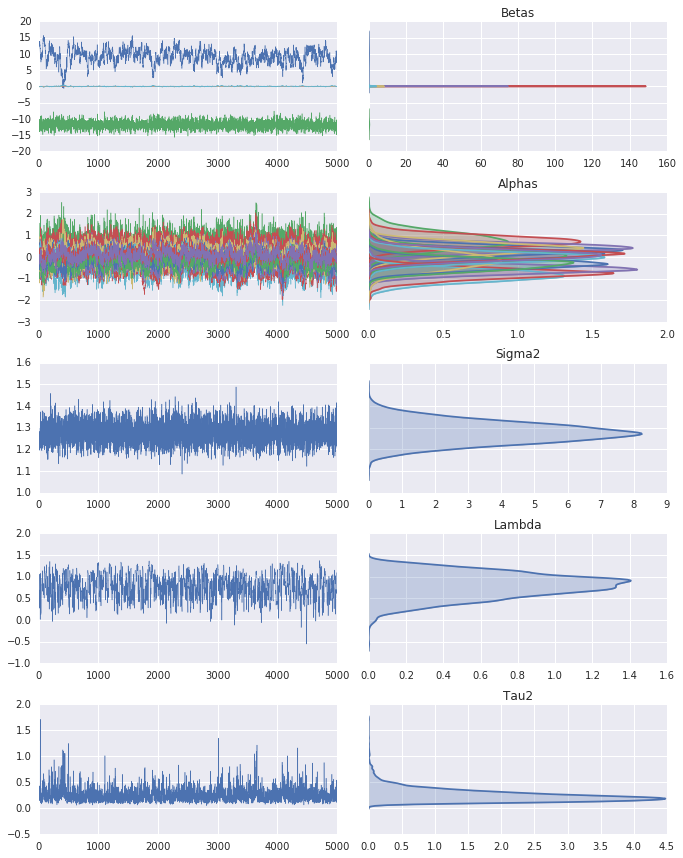

In [4]:
plot_trace(m2)
plt.tight_layout()
plt.show()

In [3]:
from hlm import sqlite as sql
import imp
imp.reload(sql)

<module 'hlm.sqlite' from '/home/ljw/Downloads/hlm_gibbs/hlm/sqlite.py'>

In [4]:
!rm model_trace.db

In [5]:
cxn, cursor = sql.start_sql(m2)
sql.model_to_sql(m2, cursor, cxn)

NameError: name 'm2' is not defined

In [9]:
m, t, s = sql.model_from_sql('model_trace.db')

/home/ljw/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: initializing model <class 'hlm.upper_level.sma.model.Upper_SMA'> from state failed! Returning trace, state, model.
  if __name__ == '__main__':


In [10]:
for k in s.varnames:
    try:
        np.testing.assert_allclose(m2.state.get(k, None), s.get(k, None))
    except TypeError:
        pass

In [11]:
from hlm.trace import Trace

In [12]:
def from_st(cls, state, trace, model_type=None):
    if model_type == None:
        out = cls()
        out.state = state
        out.trace = trace
    else:
        X = np.zeros((9,1))
        Y = np.zeros((9,1))
        W = ps.lat2W(3,3)
        M = ps.lat2W(2,2)
        membership = np.array([0,0,1,1,2,2,2,3,3])
        try:
            out = model_type(X, Y, 
                             M=M, W=W, 
                             membership=membership,
                             n_samples=0)
        except TypeError:
            try:
                out = model_type(X, Y, 
                                 M=M,  
                                 membership=membership,
                                 n_samples=0)
            except TypeError:
                out = model_type(X, Y, 
                                 W=W,  
                                 membership=membership,
                                 n_samples=0)
        out.state = state
        out.trace = trace
    return out

In [13]:
out = from_st(m, s, t, model_type=m)

/home/ljw/Downloads/hlm_gibbs/hlm/verify.py:27: UserWarning: X array should not contain a constant vector; constant will be added automatically
  Warn("X array should not contain a constant vector;"
/home/ljw/Downloads/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


In [6]:
m3 = hlm.upper.SMA(Y, X, M=W2, Z=ZDurbin, 
                   membership=membership, n_samples=0)

/home/ljw/Downloads/hlm_gibbs/hlm/utils.py:91: ComplexWarning: Casting complex values to real discards the imaginary part
  emax = emax.astype(float)
/home/ljw/Downloads/hlm_gibbs/hlm/utils.py:92: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


In [7]:
!rm model_trace.db

rm: cannot remove 'model_trace.db': No such file or directory


In [8]:
m3.database = 'model_trace.db'

In [9]:
m3.sample(1)

In [10]:
m3.trace.Alphas

[array([[ 0.51406376],
        [ 1.31884385],
        [ 1.12641117],
        [ 0.33376298],
        [ 0.3794173 ],
        [-1.00694135],
        [ 0.60489805],
        [ 0.41949272],
        [-0.4416009 ],
        [-0.68022562],
        [ 0.22741207],
        [ 0.45501258],
        [-0.37240093],
        [-0.03609596],
        [ 0.64517456],
        [ 0.01506129]])]

In [11]:
m3.draw()

In [12]:
m3.trace.Alphas

[array([[ 0.42369249],
        [ 0.53919636],
        [ 0.93734661],
        [ 0.29954538],
        [ 0.46690972],
        [-1.11643547],
        [ 0.34850171],
        [ 0.37593373],
        [-0.31447547],
        [-0.34706737],
        [ 0.2601574 ],
        [ 0.25289965],
        [-0.32639214],
        [-0.04952317],
        [ 0.4491028 ],
        [ 0.1675821 ]])]

In [14]:
m3.sample(1000)

In [15]:
m3.trace

{Betas:[array([[  9.54850998e+00],
       [ -1.04573327e+01],
       [ -2.26295042e-03],
       [  2.96751207e-02],
       [ -3.10836891e-02],
       [ -6.48996004e-02]])], Lambda:[0.92236665877552393], Tau2:[0.16126437375218539], Sigma2:[1.2548979534147204], Alphas:[array([[ 0.24010175],
       [ 0.79991833],
       [ 0.82784041],
       [ 0.51697704],
       [ 0.05528767],
       [-0.6529749 ],
       [-0.11558707],
       [-0.06598505],
       [-1.17276524],
       [-0.34030764],
       [-0.1835031 ],
       [ 0.03155321],
       [-0.31898888],
       [-0.29284228],
       [ 0.02371079],
       [ 0.1117099 ]])]}

In [16]:
results = hlm.sqlite.trace_from_sql(m3.database)

/home/ljw/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(<matplotlib.figure.Figure at 0x7f11898a9550>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f11899c5f28>,
         <matplotlib.axes._subplots.AxesSubplot object at 0x7f11840bb358>]], dtype=object))

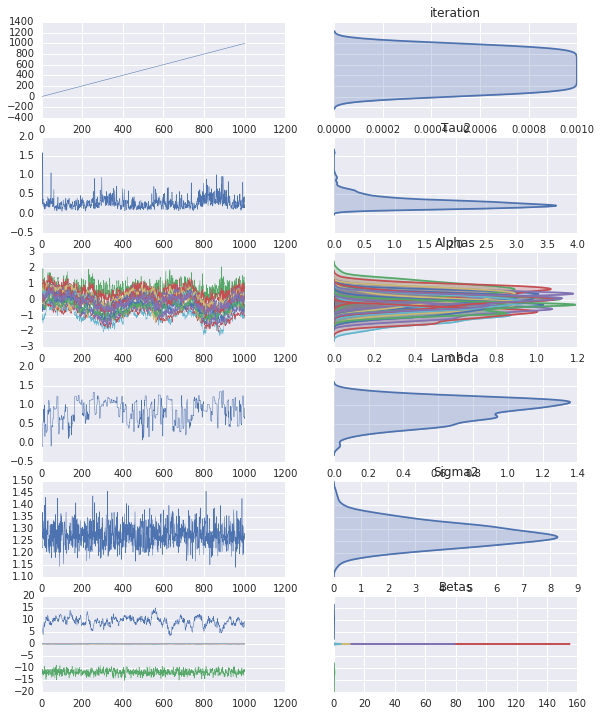

In [17]:
results.plot()